# Partie 2 : Clustering

In [1]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import cluster, metrics
from scipy.spatial.distance import cdist
from sklearn import decomposition, manifold
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

sns.set()
plt.style.use('seaborn-whitegrid')

In [2]:
data = pd.read_csv("data.csv")

## Détermination du nombre optimal de clusters

### Coefficient de silhouette

- d'après le coefficient de silhouette et la méthode du coude on choisira 4 ou 5 clusters (en fonction de la meilleure utilisation business)

In [3]:
X = data[['recency', 'monetary', 'satisfaction']]
X_scaled = preprocessing.StandardScaler().fit_transform(X)

Text(0.5, 1.0, 'Coefficient de silhouette en fonction du nombre de clusters')

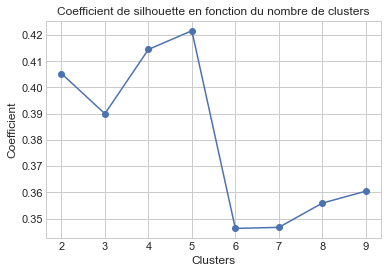

In [4]:
silhouettes = []
for num_clusters in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_clusters, random_state=0)
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')
plt.ylabel('Coefficient')
plt.xlabel('Clusters')
plt.title("Coefficient de silhouette en fonction du nombre de clusters")

### Méthode du "coude"

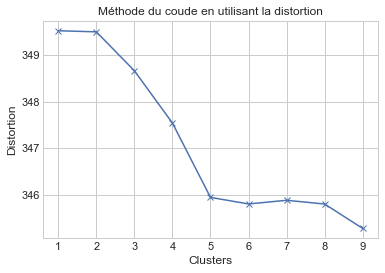

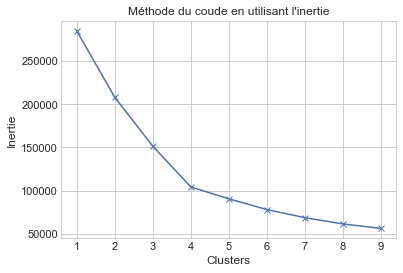

In [5]:
distortions = []
inertias = []
K = range(1, 10)

for num_clusters in K:
    cls = cluster.KMeans(n_clusters=num_clusters, random_state=0)
    cls.fit(X_scaled)

    distortions.append(sum(np.min(cdist(X, cls.cluster_centers_,
                       'euclidean'), axis=1)) / X.shape[0])
    inertias.append(cls.inertia_)

plt.plot(K, distortions, '-bx')
plt.xlabel('Clusters')
plt.ylabel('Distortion')
plt.title('Méthode du coude en utilisant la distortion')
plt.show()

plt.plot(K, inertias, '-bx')
plt.xlabel('Clusters')
plt.ylabel('Inertie')
plt.title("Méthode du coude en utilisant l'inertie")
plt.show()

## Test des différents algorithmes
### K-means

- Nombre de clusters exploitables : 4 ou 5

#### Visualisation des clusters de K-means

In [6]:
def pca_plot(X, model):
    '''
    Fonction pour appliquer une ACP et afficher les clusters
    sur les deux premières composantes principales
    '''
    X_scaled = preprocessing.StandardScaler().fit_transform(X)
    pca = decomposition.PCA(n_components=2)
    pca.fit(X_scaled)
    print(pca.explained_variance_ratio_.cumsum())
    X_trans = pca.transform(X_scaled)

    fig = plt.figure(figsize=(12, 5))
    model.fit(X_scaled)
    sns.relplot(x=X_trans[:, 0], y=X_trans[:, 1],
                hue=model.labels_, kind='scatter')
    return(model.labels_)

In [7]:
def tsne_plot(X, model):
    '''
    Fonction pour appliquer une t-sne et afficher les clusters
    sur les deux premières composantes principales
    '''
    X_scaled = preprocessing.StandardScaler().fit_transform(X)
    tsne = manifold.TSNE(n_components=2, init='pca')
    X_trans = tsne.fit_transform(X_scaled)
    fig = plt.figure(figsize=(12, 5))
    model.fit(X_scaled)
    sns.relplot(x=X_trans[:, 0], y=X_trans[:, 1],
                hue=model.labels_, kind='scatter')
    plt.title("Visualisation des clusters après t-SNE")
    return(model.labels_)

[0.34719478 0.68042982]


<Figure size 864x360 with 0 Axes>

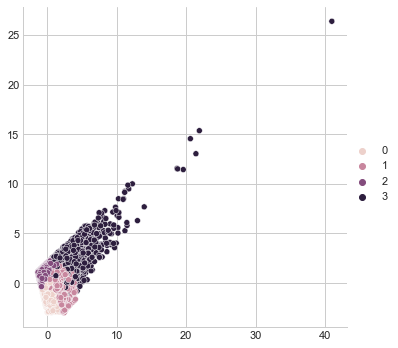

In [8]:
X = data[['recency', 'monetary', 'satisfaction']]
km4 = cluster.KMeans(n_clusters=4, random_state=0)
km4_labels = pca_plot(X, km4)

[0.34719478 0.68042982]


<Figure size 864x360 with 0 Axes>

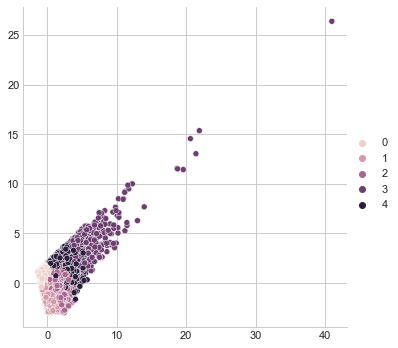

In [9]:
km5 = cluster.KMeans(n_clusters=5, random_state=0)
km5_labels = pca_plot(X, km5)

<Figure size 864x360 with 0 Axes>

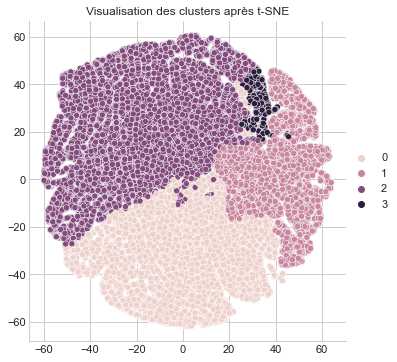

In [10]:
km4_labels = tsne_plot(X, km4)

<Figure size 864x360 with 0 Axes>

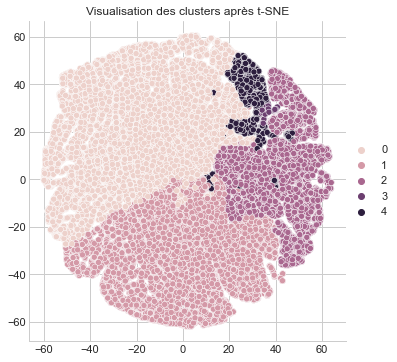

In [11]:
km5_labels = tsne_plot(X, km5)

#### Etude des clusters de K-means

##### 4 clusters :
- "clients mécontents" : clients peu satisfaits
- "anciens clients" : ont acheté il y a longtemps
- "clients grosses dépenses" : gros montant et dans l'ensemble satisfaits
- "nouveaux clients" : ont acheté récemment et sont satisfaits


In [12]:
X_clustered = X.copy()
X_clustered['cluster_km4'] = km4_labels
X_clustered['cluster_km5'] = km5_labels

1er cluster :

- montant des achats faible/moyen, satisfaction bonne
- caractéristique principale : achat il y a longtemps
- on peut les classer comme "anciens clients"

In [13]:
X_clustered[X_clustered['cluster_km4'] == 0].describe()

,recency,monetary,satisfaction,cluster_km4,cluster_km5
count,32561.000000,32561.000000,32561.000000,32561.0,32561.000000
mean,442.316606,115.264251,4.629342,0.0,1.061270
std,95.150077,106.837158,0.596816,0.0,0.424335
min,306.000000,2.290000,2.000000,0.0,1.000000
25%,358.000000,45.900000,4.000000,0.0,1.000000
50%,432.000000,83.900000,5.000000,0.0,1.000000
75%,514.000000,145.970000,5.000000,0.0,1.000000
max,745.000000,739.980000,5.000000,0.0,4.000000


2e cluster:

- montant des achats faible/moyen, achats répartis dans le temps
- caractéristique principale : clients peu satisfaits
- on peut les classer comme "clients mécontents"

In [14]:
X_clustered[X_clustered['cluster_km4'] == 1].describe()

,recency,monetary,satisfaction,cluster_km4,cluster_km5
count,17065.000000,17065.000000,17065.000000,17065.0,17065.000000
mean,288.393613,130.196528,1.637562,1.0,2.030237
std,129.976388,121.162645,0.830492,0.0,0.258289
min,45.000000,3.540000,1.000000,1.0,0.000000
25%,206.000000,49.900000,1.000000,1.0,2.000000
50%,269.000000,92.000000,1.000000,1.0,2.000000
75%,347.000000,164.000000,2.000000,1.0,2.000000
max,773.000000,759.000000,3.000000,1.0,4.000000


3e cluster :

- montant des achats faible/moyen, satisfaction bonne
- caractéristique principale : achat récent
- on peut les classer comme "nouveaux clients"

In [15]:
X_clustered[X_clustered['cluster_km4'] == 2].describe()

,recency,monetary,satisfaction,cluster_km4,cluster_km5
count,43131.000000,43131.000000,43131.000000,43131.0,43131.000000
mean,171.375554,114.504058,4.672556,2.0,0.080684
std,72.568061,103.205144,0.555363,0.0,0.562348
min,50.000000,0.850000,3.000000,2.0,0.000000
25%,108.000000,45.000000,4.000000,2.0,0.000000
50%,168.000000,85.000000,5.000000,2.0,0.000000
75%,234.000000,148.900000,5.000000,2.0,0.000000
max,307.000000,682.980000,5.000000,2.0,4.000000


4e cluster:

- achats répartis dans le temps, satisfaction variable, mais majoritairement bonne
- caractéristique principale : montant des achats élevés
- on peut les classer comme "clients aux dépenses élevées"


In [16]:
X_clustered[X_clustered['cluster_km4'] == 3].describe()

,recency,monetary,satisfaction,cluster_km4,cluster_km5
count,2226.000000,2226.000000,2226.000000,2226.0,2226.000000
mean,285.745732,1159.390458,4.048967,3.0,3.806379
std,150.899333,667.263514,1.387855,0.0,0.395224
min,50.000000,619.000000,1.000000,3.0,3.000000
25%,160.250000,790.000000,4.000000,3.0,4.000000
50%,267.500000,949.990000,5.000000,3.0,4.000000
75%,396.000000,1300.000000,5.000000,3.0,4.000000
max,743.000000,13440.000000,5.000000,3.0,4.000000


In [17]:
segt_map = {'0' : 'anciens clients',
            '1' : 'clients\nmécontents',
            '2' : 'nouveaux clients',
            '3' : 'clients aux\ndépenses élevées'}

X_label = X_clustered.copy()
X_label['label_4_cls'] = X_label['cluster_km4'].astype(str).replace(segt_map, regex=True)

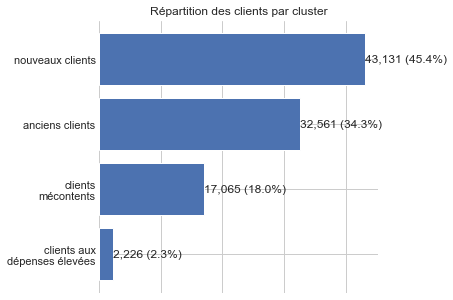

In [18]:
def count_segment(labels):
    '''
    Fonction pour compter le nombre de points
    dans chaque cluster
    '''
    segments_counts = labels.value_counts().sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(5, 5))

    bars = ax.barh(range(len(segments_counts)),
                   segments_counts)
    ax.set_frame_on(False)
    ax.tick_params(left=False,
                   bottom=False,
                   labelbottom=False)
    ax.set_yticks(range(len(segments_counts)))
    ax.set_yticklabels(segments_counts.index)

    for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                     round(value*100/segments_counts.sum(),
                                           1)),
                va='center',
                ha='left'
                )
    plt.title("Répartition des clients par cluster")
    plt.show()


count_segment(X_label['label_4_cls'])

##### 5 clusters :
- mêmes clusters que précédemment avec une division des clients aux dépenses élevées et plus d'importance aux dépenses car certains clients des autres groupes se retrouvent dans le cluster des grosses dépenses.

1er cluster:

- montant des achats faible/moyen, satisfaction bonne
- caractéristique principale : achat récent
- on peut les classer comme "nouveaux clients"

In [19]:
X_clustered[X_clustered['cluster_km5'] == 0].describe()

,recency,monetary,satisfaction,cluster_km4,cluster_km5
count,42274.000000,42274.00000,42274.000000,42274.000000,42274.0
mean,171.273951,105.75748,4.672210,1.999692,0.0
std,72.598953,83.73764,0.556568,0.017534,0.0
min,50.000000,0.85000,3.000000,1.000000,0.0
25%,108.000000,44.98000,4.000000,2.000000,0.0
50%,168.000000,82.00000,5.000000,2.000000,0.0
75%,234.000000,139.99000,5.000000,2.000000,0.0
max,307.000000,489.06000,5.000000,2.000000,0.0


2e cluster:

- montant des achats faible/moyen, satisfaction bonne
- caractéristique principale : achat il y a longtemps
- on peut les classer comme "anciens clients"

In [20]:
X_clustered[X_clustered['cluster_km5'] == 1].describe()

,recency,monetary,satisfaction,cluster_km4,cluster_km5
count,31902.000000,31902.000000,31902.000000,31902.000000,31902.0
mean,442.605385,106.077538,4.628895,0.000188,1.0
std,95.101316,86.149362,0.597464,0.013713,0.0
min,306.000000,2.290000,2.000000,0.000000,1.0
25%,359.000000,45.000000,4.000000,0.000000,1.0
50%,433.000000,79.900000,5.000000,0.000000,1.0
75%,515.000000,139.900000,5.000000,0.000000,1.0
max,745.000000,599.600000,5.000000,1.000000,1.0


3e cluster:

- montant des achats faible/moyen, achats répartis dans le temps
- caractéristique principale : clients peu satisfaits
- on peut les classer comme "clients mécontents"

In [21]:
X_clustered[X_clustered['cluster_km5'] == 2].describe()

,recency,monetary,satisfaction,cluster_km4,cluster_km5
count,16772.000000,16772.000000,16772.000000,16772.0,16772.0
mean,288.330789,122.637865,1.628905,1.0,2.0
std,129.901353,105.617752,0.826716,0.0,0.0
min,45.000000,3.540000,1.000000,1.0,2.0
25%,206.000000,49.000000,1.000000,1.0,2.0
50%,269.000000,89.990000,1.000000,1.0,2.0
75%,347.000000,159.755000,2.000000,1.0,2.0
max,773.000000,637.900000,3.000000,1.0,2.0


4e cluster:

- achats répartis dans le temps, satisfaction variable, mais majoritairement bonne
- caractéristique principale : montant des achats très élevés
- on peut les classer comme "clients aux dépenses très élevées"


In [22]:
X_clustered[X_clustered['cluster_km5'] == 3].describe()

,recency,monetary,satisfaction,cluster_km4,cluster_km5
count,431.000000,431.000000,431.000000,431.0,431.0
mean,284.916473,2129.488608,3.807425,3.0,3.0
std,163.166650,975.469714,1.569340,0.0,0.0
min,54.000000,1429.900000,1.000000,3.0,3.0
25%,148.000000,1630.000000,3.000000,3.0,3.0
50%,255.000000,1890.000000,5.000000,3.0,3.0
75%,398.500000,2199.995000,5.000000,3.0,3.0
max,630.000000,13440.000000,5.000000,3.0,3.0


5e cluster :

- achats répartis dans le temps, satisfaction variable, mais majoritairement bonne
- caractéristique principale : montant des achats plus élevé que la moyenne
- on peut les classer comme "clients aux dépenses élevées"


In [23]:
X_clustered[X_clustered['cluster_km5'] == 4].describe()

,recency,monetary,satisfaction,cluster_km4,cluster_km5
count,3604.000000,3604.000000,3604.000000,3604.000000,3604.0
mean,286.421199,739.409412,4.184517,2.052997,4.0
std,147.680223,243.365920,1.230149,1.144425,0.0
min,50.000000,389.000000,1.000000,0.000000,4.0
25%,167.000000,550.000000,4.000000,1.000000,4.0
50%,270.000000,675.445000,5.000000,2.000000,4.0
75%,388.000000,879.000000,5.000000,3.000000,4.0
max,743.000000,1442.600000,5.000000,3.000000,4.0


In [24]:
segt_map = {'0' : 'nouveaux clients',
            '1' : 'anciens clients',
            '2' : 'clients\nmécontents',
            '3' : 'clients aux\ndépenses très élevées',
            '4' : 'clients aux\ndépenses élevées'}

X_label['label_5_cls'] = X_label['cluster_km5'].astype(str).replace(segt_map, regex=True)

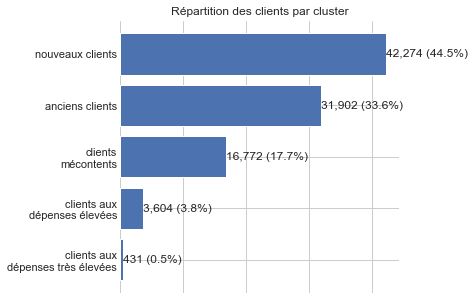

In [25]:
count_segment(X_label['label_5_cls'])

In [26]:
X_diff = X_label[X_label['label_4_cls'] != X_label['label_5_cls']]
X_diff = X_diff[['recency', 'label_4_cls', 'label_5_cls']]
X_diff['label_4_cls'] = X_diff['label_4_cls'].str.replace('\n', ' ')
X_diff['label_5_cls'] = X_diff['label_5_cls'].str.replace('\n', ' ')
X_diff.rename(columns={'recency':'nb_customers'}, inplace=True)
X_diff.groupby(['label_4_cls', 'label_5_cls']).count()

nb_customers
label_4_cls                  label_5_cls                                    
anciens clients              clients aux dépenses élevées                665
clients aux dépenses élevées clients aux dépenses très élevées           431
clients mécontents           anciens clients                               6
                             clients aux dépenses élevées                274
                             nouveaux clients                             13
nouveaux clients             clients aux dépenses élevées                870

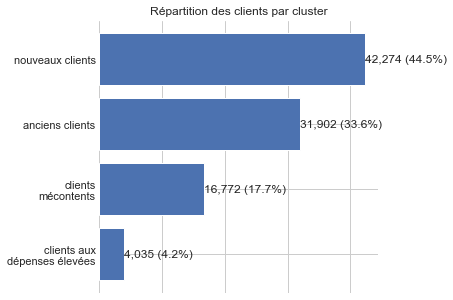

In [27]:
# on peut obtenir 4 clusters plus pertinents
# en regroupant les deux plus petits clusters
X_label['cluster'] = np.where(X_label['cluster_km5'] == 3,
                              'clients aux\ndépenses élevées',
                              X_label['label_5_cls'])
segt_map = {'nouveaux clients' : 0,
            'anciens clients' : 1,
            'clients\nmécontents' : 2,
            'clients aux\ndépenses élevées' : 3}

X_label['n_cluster'] = X_label['cluster'].astype(str).replace(segt_map, regex=True)

count_segment(X_label['cluster'])

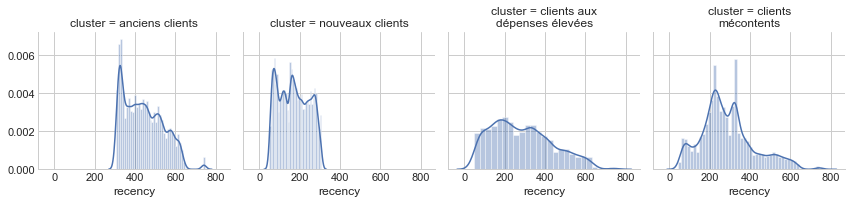

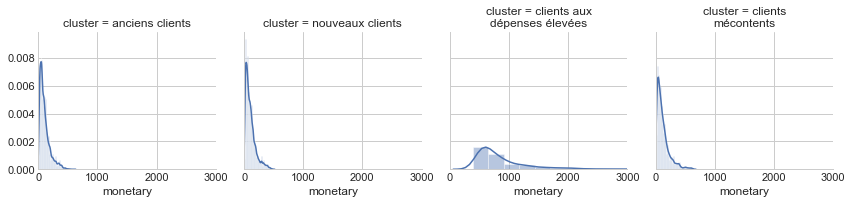

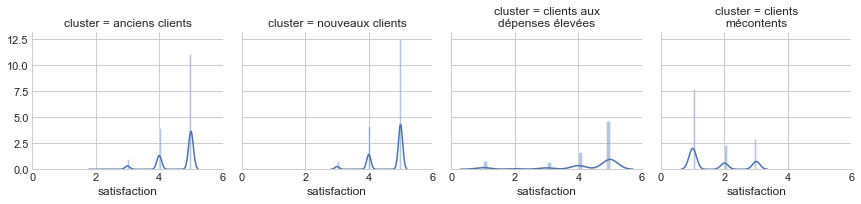

In [28]:
for c in X_label[['recency', 'monetary', 'satisfaction']]:
    grid = sns.FacetGrid(X_label, col='cluster')
    if c == "monetary":
        grid.set(xlim=(0, 3000))
    grid.map(sns.distplot, c)

In [29]:
df = X_label[['n_cluster', 'recency', 'monetary', 'satisfaction']].copy()
df = df[df['monetary'] < 2000]

In [30]:
labels = ['nouveaux clients\n42974 (44%)',
          'anciens clients\n31902 (34%)',
          'clients\nmécontents\n16772 (18%)',
          'clients aux\ndépenses élevées\n4035 (4%)']
colors = ListedColormap(['steelblue', 'turquoise',
                         'teal', 'paleturquoise'])

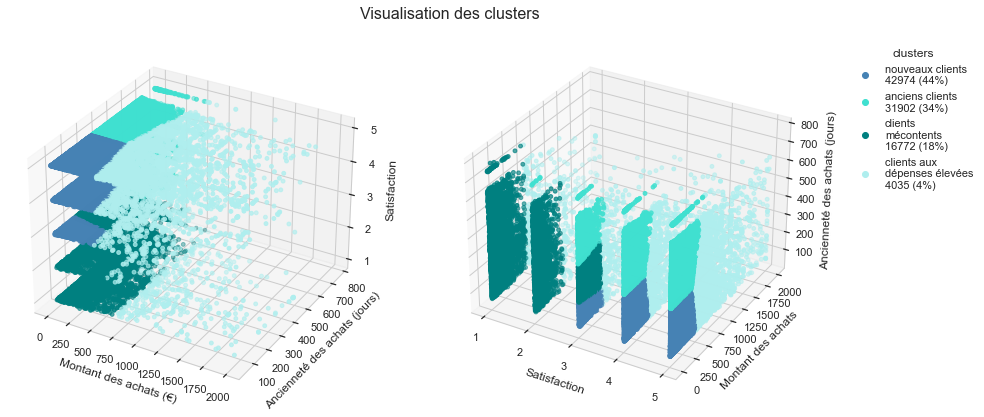

In [31]:
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(141, projection='3d')
ax.scatter(df.monetary, df.recency, df.satisfaction,
           c=df["n_cluster"], cmap=colors, s=15, label=labels)
ax.set_xlabel('Montant des achats (€)')
ax.set_ylabel('Ancienneté des achats (jours)')
ax.set_zlabel('Satisfaction')
ax.set_zticks([1, 2, 3, 4, 5])

ax = fig.add_subplot(142, projection='3d')
sc = ax.scatter(df.satisfaction, df.monetary, df.recency,
                c=df["n_cluster"], cmap=colors, s=15, label=labels)
ax.set_xlabel('Satisfaction')
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_ylabel('Montant des achats')
ax.set_zlabel('Ancienneté des achats (jours)')

plt.suptitle("Visualisation des clusters", x=0.33, y=0.8, fontsize=16)
plt.legend(handles=sc.legend_elements()[0], labels=labels,
           title='clusters', bbox_to_anchor=(1.1, 1),
           loc="upper left")
plt.show()

### DBSCAN

- Nombre de clusters beaucoup trop élevé pour donner un résultat exploitable d'un point de vue business.

In [32]:
X = data[['recency', 'satisfaction', 'monetary']]
X_scaled = preprocessing.StandardScaler().fit_transform(X)

db = cluster.DBSCAN().fit(X_scaled)
labels = db.labels_

# Nombre de clusters dans labels,
# en soustrayant le bruit si présent
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('Nombre de clusters : %d' % n_clusters)
print('Nombre de points de bruit : %d' % n_noise)
print("Coefficient de silhouette : %0.3f"
      % metrics.silhouette_score(X_scaled, labels))

Nombre de clusters : 17
Nombre de points de bruit : 173
Coefficient de silhouette : 0.098


### Classification hierarchique

- Problème de mémoire : on ne peut pas faire le clustering sur tout le dataset

#### Méthode 1 :

- On réduit le jeu de données en faisant un premier clustering avec K-means.
- test avec 1000 clusters et 100 clusters par Kmeans : même résultat, le dendrogramme donne 4 clusters. On utilisera 100 pour la lisibilité.

In [33]:
X = data[['recency', 'satisfaction', 'monetary']].copy()
X_scaled = preprocessing.StandardScaler().fit_transform(X)

cls = cluster.KMeans(n_clusters=100, random_state=0)
cls.fit(X_scaled)
X['cluster_100'] = cls.labels_

cls = cluster.KMeans(n_clusters=4, random_state=0)
cls.fit(X_scaled)
X['cluster_4'] = cls.labels_

X = X.drop_duplicates(subset='cluster_100')

In [34]:
X_cah = X[['recency', 'satisfaction', 'monetary']]
cah_labels = np.array(X['cluster_4'])
X_scaled = preprocessing.StandardScaler().fit_transform(X_cah)

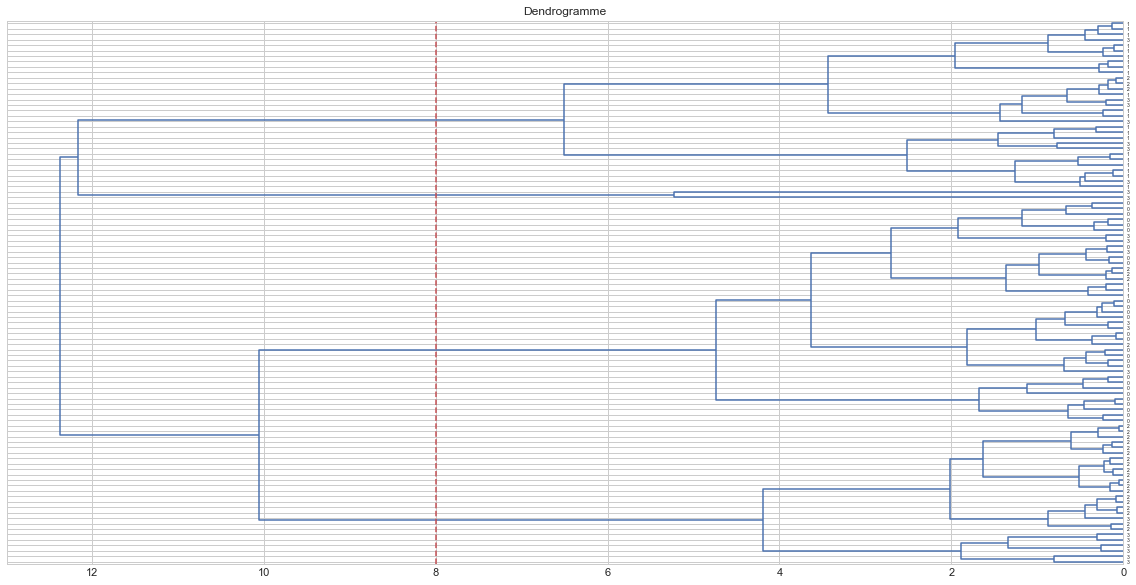

In [35]:
fig = plt.figure(figsize=(20, 10))

Z = linkage(X_scaled, method='ward', metric='euclidean')
plt.title("Dendrogramme")
dendrogram(Z, labels=cah_labels, orientation='left',
           color_threshold=0)
plt.axvline(x=8, color='r', linestyle='--')
plt.show()


#### Méthode 2 :

- On prend un échantillon du dataset au hasard

In [36]:
X = data.sample(n=1000, random_state=0)
X = X[['recency', 'satisfaction', 'monetary']]
X_scaled = preprocessing.StandardScaler().fit_transform(X)

cls = cluster.KMeans(n_clusters=4, random_state=0)
cls.fit(X_scaled)
X['cluster_4'] = cls.labels_

X_cah = X[['recency', 'satisfaction', 'monetary']]
cah_labels = np.array(X['cluster_4'])
X_scaled = preprocessing.StandardScaler().fit_transform(X_cah)

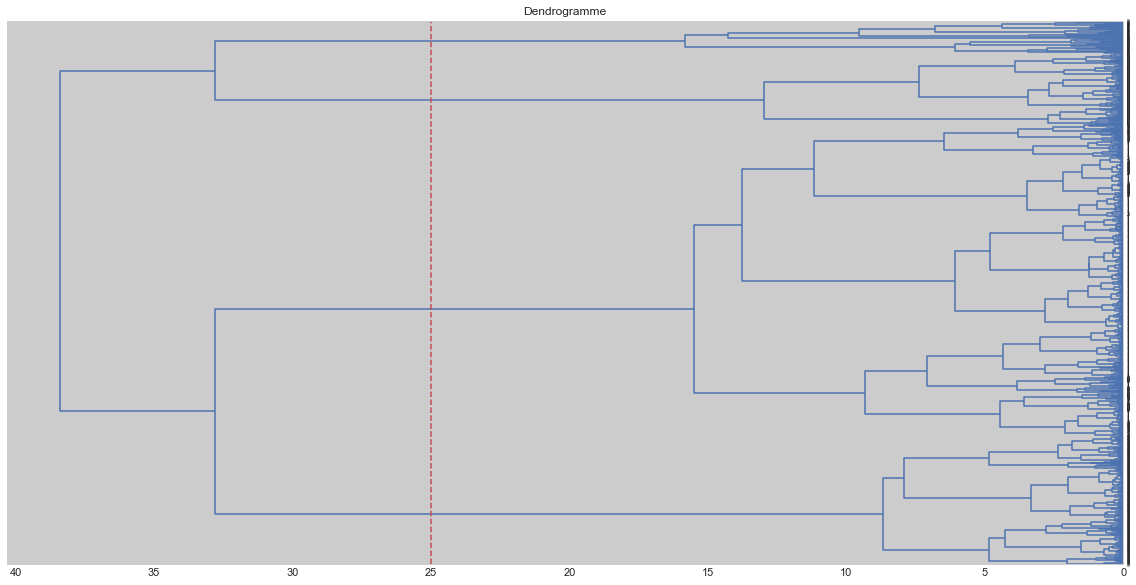

In [37]:
fig = plt.figure(figsize=(20, 10))

Z = linkage(X_scaled, method='ward', metric='euclidean')
plt.title("Dendrogramme")
dendrogram(Z, labels=cah_labels, orientation='left',
           color_threshold=0)
plt.axvline(x=25, color='r', linestyle='--')
plt.show()

#### Visualisation des clusters de CAH

[0.34851181 0.6786507 ]


array([0, 0, 0, ..., 2, 0, 2], dtype=int64)

<Figure size 864x360 with 0 Axes>

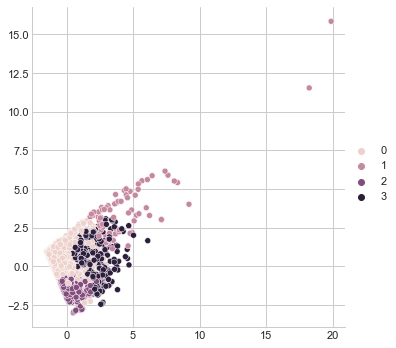

In [38]:
X = X_label.sample(n=10000, random_state=0)
label_kmeans = X['cluster']
X = X[['recency', 'satisfaction', 'monetary']]
CAH = AgglomerativeClustering(n_clusters=4,
                              affinity='euclidean',
                              linkage='ward')
pca_plot(X, CAH)

<Figure size 864x360 with 0 Axes>

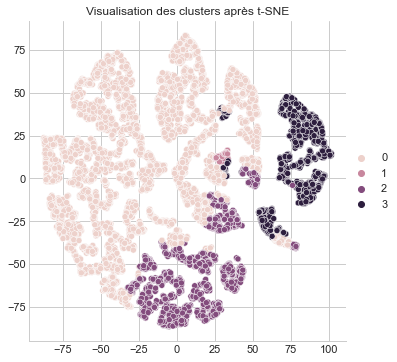

In [39]:
cah_labels = tsne_plot(X, CAH)

In [40]:
metrics.silhouette_score(X, cah_labels)

0.17071858583155175

### Etude des clusters de CAH

In [41]:
X['cluster_cah'] = cah_labels
X['cluster_kmeans'] = label_kmeans

In [42]:
# majorité de nouveaux clients
X[X['cluster_cah'] == 0].describe()

,recency,satisfaction,monetary,cluster_cah
count,6641.000000,6641.000000,6641.000000,6641.0
mean,227.707273,4.492998,131.310319,0.0
std,111.844076,0.735904,149.024202,0.0
min,50.000000,2.000000,0.850000,0.0
25%,136.000000,4.000000,45.000000,0.0
50%,219.000000,5.000000,85.000000,0.0
75%,313.000000,5.000000,149.990000,0.0
max,743.000000,5.000000,1199.900000,0.0


In [43]:
# clients dépenses élevées
X[X['cluster_cah'] == 1].describe()

,recency,satisfaction,monetary,cluster_cah
count,76.000000,76.000000,76.000000,76.0
mean,266.776316,4.236842,1859.237763,1.0
std,148.152228,1.263523,979.795640,0.0
min,58.000000,1.000000,1099.000000,1.0
25%,132.250000,4.000000,1300.000000,1.0
50%,241.500000,5.000000,1599.495000,1.0
75%,399.250000,5.000000,2024.227500,1.0
max,612.000000,5.000000,7160.000000,1.0


In [44]:
# anciens clients
X[X['cluster_cah'] == 2].describe()

,recency,satisfaction,monetary,cluster_cah
count,1973.000000,1973.000000,1973.000000,1973.0
mean,493.676128,4.678662,98.774962,2.0
std,76.685073,0.662021,67.181683,0.0
min,346.000000,2.000000,6.000000,2.0
25%,429.000000,5.000000,46.990000,2.0
50%,494.000000,5.000000,84.900000,2.0
75%,552.000000,5.000000,135.000000,2.0
max,744.000000,5.000000,478.300000,2.0


In [45]:
# clients mécontents
X[X['cluster_cah'] == 3].describe()

,recency,satisfaction,monetary,cluster_cah
count,1310.000000,1310.000000,1310.000000,1310.0
mean,278.186260,1.247328,177.756420,3.0
std,144.301083,0.527231,204.494282,0.0
min,50.000000,1.000000,3.540000,3.0
25%,180.000000,1.000000,56.300000,3.0
50%,250.500000,1.000000,107.895000,3.0
75%,338.000000,1.000000,198.975000,3.0
max,744.000000,4.000000,1540.000000,3.0


In [46]:
segt_map = {'0' : 'nouveaux clients',
            '1' : 'clients aux\ndépenses élevées',
            '2' : 'anciens clients',
            '3' : 'clients\nmécontents'}

X['label_cah'] = X['cluster_cah'].astype(str).replace(segt_map, regex=True)

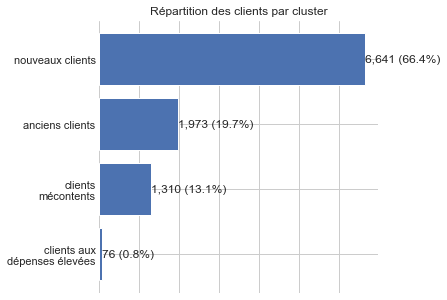

In [47]:
count_segment(X['label_cah'])

### Comparaison avec clusters de kmeans
Les clusters sont moins bien définis qu'avec kmeans et plus difficiles à expliquer d'un point de vue business. De plus on ne peut le faire que sur un échantillon du dataset.

In [48]:
X_diff = X[X['label_cah'] != X['cluster_kmeans']]
X_diff = X_diff[['recency', 'label_cah', 'cluster_kmeans']]
X_diff['label_cah'] = X_diff['label_cah'].str.replace('\n', ' ')
X_diff['cluster_kmeans'] = X_diff['cluster_kmeans'].str.replace('\n', ' ')
X_diff.rename(columns={'recency':'nb_customers'}, inplace=True)
X_diff.groupby(['label_cah', 'cluster_kmeans']).count()

nb_customers
label_cah          cluster_kmeans                            
anciens clients    clients mécontents                      38
clients mécontents clients aux dépenses élevées            83
                   nouveaux clients                         2
nouveaux clients   anciens clients                       1399
                   clients aux dépenses élevées           274
                   clients mécontents                     496

In [49]:
df = X[['cluster_cah', 'recency', 'monetary', 'satisfaction']].copy()
df = df[df['monetary'] < 2000]

In [50]:
labels = ['nouveaux clients',
          'anciens clients',
          'clients\nmécontents',
          'clients aux\ndépenses élevées']
colors = ListedColormap(['steelblue', 'turquoise',
                         'teal', 'paleturquoise'])

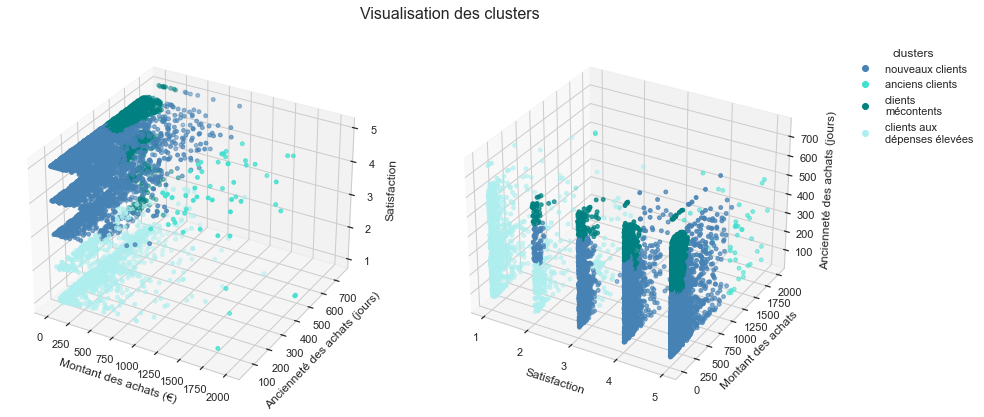

In [51]:
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(141, projection='3d')
ax.scatter(df.monetary, df.recency, df.satisfaction,
           c=df["cluster_cah"], cmap=colors, s=15, label=labels)
ax.set_xlabel('Montant des achats (€)')
ax.set_ylabel('Ancienneté des achats (jours)')
ax.set_zlabel('Satisfaction')
ax.set_zticks([1, 2, 3, 4, 5])

ax = fig.add_subplot(142, projection='3d')
sc = ax.scatter(df.satisfaction, df.monetary, df.recency,
                c=df["cluster_cah"], cmap=colors, s=15, label=labels)
ax.set_xlabel('Satisfaction')
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_ylabel('Montant des achats')
ax.set_zlabel('Ancienneté des achats (jours)')

plt.suptitle("Visualisation des clusters", x=0.33, y=0.8, fontsize=16)
plt.legend(handles=sc.legend_elements()[0], labels=labels,
           title='clusters', bbox_to_anchor=(1.1, 1),
           loc="upper left")
plt.show()